# 파일 읽어서 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('./train_bic.csv', encoding='utf-8')
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [4]:
test = pd.read_csv('./test_bic.csv', encoding='utf-8')
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


# 결측치 채우기

In [5]:
## 결측치를 확인하고 결측치 채우기 (simple imputer 이용)
train.info()
print(train.isnull().sum())
print(train[train['hour_bef_pm2.5'].isnull()])

test.info()
print(test.isnull().sum())
print(test[test['hour_bef_pm2.5'].isnull()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
ho

In [6]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='mean')
imputed_df = si.fit_transform(train)
train = pd.DataFrame(imputed_df, columns = train.columns)

# si = SimpleImputer(strategy='mean')
imputed_df2 = si.fit_transform(test)
test = pd.DataFrame(imputed_df2, columns = test.columns)

<AxesSubplot:>

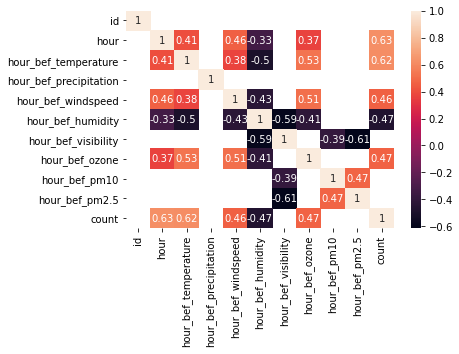

In [7]:
## 컬럼간 상관관계 확인하기
train.corr()
train.corr()[np.abs(train.corr())>=0.3]
sns.heatmap(train.corr()[np.abs(train.corr())>=0.3], annot=True)

<AxesSubplot:>

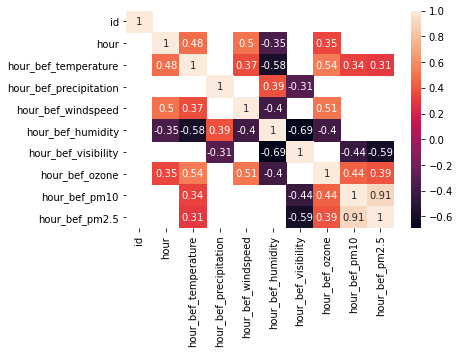

In [8]:
test.corr()
test.corr()[np.abs(test.corr())>=0.3]
sns.heatmap(test.corr()[np.abs(test.corr())>=0.3], annot=True)

train에서는 id는 상관관계가 없기 때문에 삭제하고 진행 
강수량은 상관관계가 낮으나 test에서는 상관관계가 존재하므로 삭제 안함
test는 id만 삭제하고 진행

# 모델링을 위한 데이터 분리 및 모델링

In [9]:
X_train = train.drop(columns=['id', 'count'], axis=1)
y_train = train['count']
X_test = test.drop(columns=['id'], axis=1)

print(X_train.shape, y_train.shape)
print(X_test.shape)

(1459, 9) (1459,)
(715, 9)


In [10]:
### 앙상블 모델링 진행하기
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

abc = AdaBoostRegressor(random_state=100)
gbc = GradientBoostingRegressor(random_state=100)
rf = RandomForestRegressor(random_state=100)
xgb = xgb.XGBRegressor(random_state=100)
lgb = lgb.LGBMRegressor(random_state=100, boosting_type = 'gbdt')

# help(RandomForestRegressor)

In [11]:
######### 
param_grid_abc = {
    'n_estimators': [1, 10, 50, 100],
    'loss': ['linear', 'square', 'exponential'],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0],
}

grid_search_abc = GridSearchCV(abc, param_grid=param_grid_abc, cv=10, n_jobs=-1)
grid_search_abc.fit(X_train, y_train)
print(grid_search_abc.best_estimator_)  #AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=100)

best_param_abc_gs = grid_search_abc.best_estimator_
pred_abc_gs = best_param_abc_gs.predict(X_test)

AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=100)


In [17]:
param_grid_rf = {
    'max_depth': [None, 1, 10, 15, 20],
    'max_leaf_nodes': [2],
    'criterion':["mse"],
    'n_estimators': [1, 10, 50, 100, 150, 200],
    'min_samples_split':[2,3,4,8,10],
}
param_grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=10, n_jobs=-1)
param_grid_rf.fit(X_train, y_train)
print(param_grid_rf.best_estimator_) #RandomForestRegressor(max_leaf_nodes=2, n_estimators=150, random_state=100)

best_param_rf_gs = param_grid_rf.best_estimator_
pred_rf_gs = best_param_rf_gs.predict(X_test)

RandomForestRegressor(max_leaf_nodes=2, n_estimators=150, random_state=100)


In [18]:
param_grid_gbc = {
    'n_estimators': [1, 10, 50, 100],
    'learning_rate': [0, 0.1, 0.2, 0.5, 0.8, 1.0],
    'criterion':["mse"],
    'max_depth':[None, 10, 20, 30, 50],
    'min_samples_split':[2,3,4,8,10],
}

param_grid_gbc = GridSearchCV(gbc, param_grid=param_grid_gbc, cv=10, n_jobs=-1)
param_grid_gbc.fit(X_train, y_train)
print(param_grid_gbc.best_estimator_) #GradientBoostingRegressor(criterion='mse', max_depth=10, min_samples_split=10, random_state=100)

best_param_gbc_gs = param_grid_gbc.best_estimator_ 
pred_gbc_gs = best_param_gbc_gs.predict(X_test)

C:\Users\h2est\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        n

GradientBoostingRegressor(criterion='mse', max_depth=10, min_samples_split=10,
                          random_state=100)


In [15]:
param_grid_xgb = {
    'max_depth': [None, 1, 10, 15, 20],
    'n_estimators': [1, 10, 50, 100],
#    'alpha': [0.001, 0.01, 0.1, 1],
#    'lambda': [0.001, 0.01, 0.1, 1],
    'learning_rate': [0, 0.1, 0.2, 0.5, 0.8, 1.0],
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
}
param_grid_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=10, n_jobs=-1)
param_grid_xgb.fit(X_train, y_train)
print(param_grid_xgb.best_estimator_)
            # XGBRegressor(booster='gbtree', eval_metric='rmse', learning_rate=0.1, max_depth=6, n_estimators=100, random_state=100, 
            #              reg_alpha=0, reg_lambda=1)
        
best_param_xgb_gs = param_grid_xgb.best_estimator_
pred_xgb_gs = best_param_xgb_gs.predict(X_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=100, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [16]:
param_grid_lgb = {
    'max_depth': [-1, 1, 5, 10, 15, 20],
    'n_estimators': [1, 9, 10, 50, 100],
#    'alpha': [0.001, 0.01, 0.1, 1],
#    'lambda': [0.001, 0.01, 0.1, 1],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0],
    
}
param_grid_lgb = GridSearchCV(lgb, param_grid=param_grid_lgb, cv=10, n_jobs=-1)
param_grid_lgb.fit(X_train, y_train)
print(param_grid_lgb.best_estimator_)  #LGBMRegressor(max_depth=10, random_state=100)

best_param_lgb_gs = param_grid_lgb.best_estimator_
pred_lgb_gs = best_param_lgb_gs.predict(X_test)

LGBMRegressor(max_depth=10, random_state=100)


# 성능 평가 비교

In [73]:
print('AdaBoost score: {:.3f}'.format(best_param_abc_gs.score(X_train, y_train)))
print('Random Forest score: {:.3f}'.format(best_param_rf_gs.score(X_train, y_train)))  
print('Gradient Boosting score: {:.3f}'.format(best_param_gbc_gs.score(X_train, y_train))) 
print('XGBoost score: {:.3f}'.format(best_param_xgb_gs.score(X_train, y_train))) 
print('LightGBM score: {:.3f}'.format(best_param_lgb_gs.score(X_train, y_train)))  

AdaBoost score: 0.734
Random Forest score: 0.461
Gradient Boosting score: 0.999
XGBoost score: 0.971
LightGBM score: 0.955


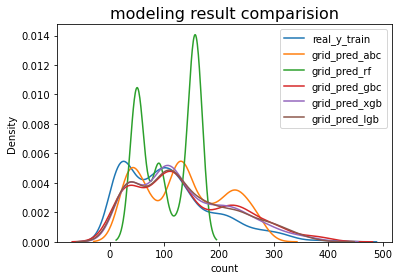

In [32]:
sns.kdeplot(y_train, label = 'real_y_train')
sns.kdeplot(pred_abc_gs, label = 'grid_pred_abc')
sns.kdeplot(pred_rf_gs, label = 'grid_pred_rf')
sns.kdeplot(pred_gbc_gs, label = 'grid_pred_gbc')
sns.kdeplot(pred_xgb_gs, label = 'grid_pred_xgb')
sns.kdeplot(pred_lgb_gs, label = 'grid_pred_lgb')
plt.title('modeling result comparision', fontsize =16)
plt.legend()
plt.show()

In [53]:
best_model = pd.DataFrame(columns = ['name', 'score'])

In [54]:
model_nm = ['Ada', 'Gradient', 'Random Forest', 'XGB', 'LGBM']
model_score = [best_param_abc_gs.score(X_train, y_train), best_param_gbc_gs.score(X_train, y_train),
              best_param_rf_gs.score(X_train, y_train), best_param_xgb_gs.score(X_train, y_train),
              best_param_lgb_gs.score(X_train, y_train)]
best_model['name'] = model_nm 
best_model['score'] = model_score

In [55]:
best_model

,name,score
0,Ada,0.733807
1,Gradient,0.999485
2,Random Forest,0.460857
3,XGB,0.970820
4,LGBM,0.955298


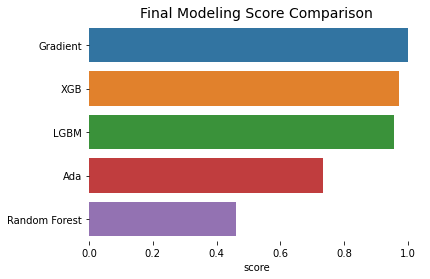

In [65]:
sns.barplot(data = best_model.sort_values(by = 'score', ascending=False), x='score', y = 'name')
sns.despine(left=True, bottom=True)
plt.title('Final Modeling Score Comparison', fontsize = 14)
plt.ylabel(None)
plt.show()

# 컬럼별 중요도 막대그래프

C:\Users\h2est\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'hour_bef_temperature'),
  Text(2, 0, 'hour_bef_humidity'),
  Text(3, 0, 'hour_bef_ozone'),
  Text(4, 0, 'hour_bef_visibility'),
  Text(5, 0, 'hour_bef_windspeed'),
  Text(6, 0, 'hour_bef_precipitation'),
  Text(7, 0, 'hour_bef_pm10'),
  Text(8, 0, 'hour_bef_pm2.5')])

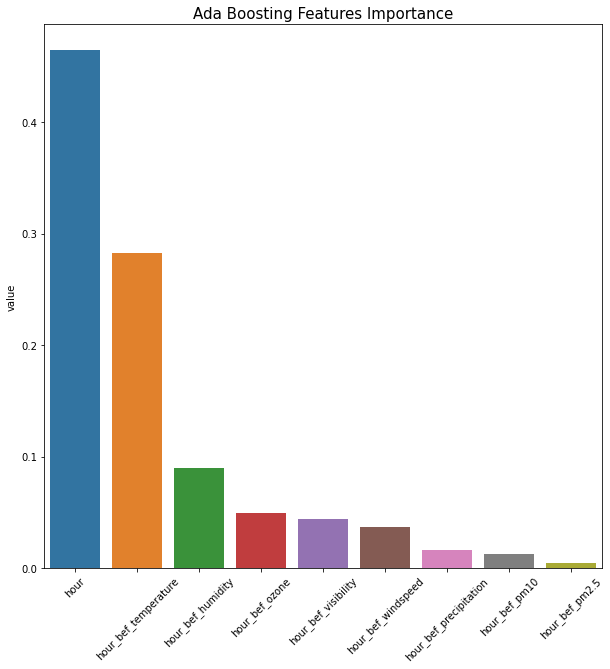

In [67]:
col_imp1 = pd.DataFrame(best_param_abc_gs.feature_importances_, index = X_train.columns, columns = ['value']).sort_values(by='value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(col_imp1.index, col_imp1['value'])
plt.title('Ada Boosting Features Importance', fontsize=15)
plt.xticks(rotation=45)

C:\Users\h2est\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'hour_bef_temperature'),
  Text(2, 0, 'hour_bef_precipitation'),
  Text(3, 0, 'hour_bef_windspeed'),
  Text(4, 0, 'hour_bef_humidity'),
  Text(5, 0, 'hour_bef_visibility'),
  Text(6, 0, 'hour_bef_ozone'),
  Text(7, 0, 'hour_bef_pm10'),
  Text(8, 0, 'hour_bef_pm2.5')])

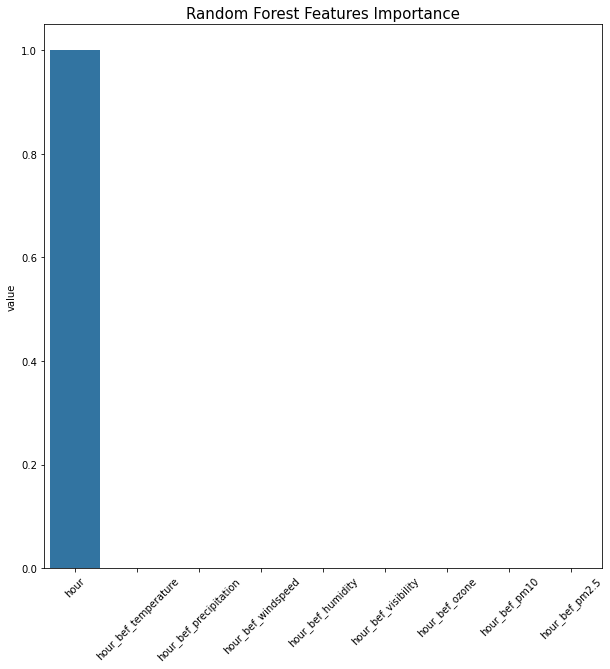

In [68]:
col_imp2 = pd.DataFrame(best_param_rf_gs.feature_importances_, index = X_train.columns, columns = ['value']).sort_values(by='value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(col_imp2.index, col_imp2['value'])
plt.title('Random Forest Features Importance', fontsize=15)
plt.xticks(rotation=45)

C:\Users\h2est\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'hour_bef_temperature'),
  Text(2, 0, 'hour_bef_ozone'),
  Text(3, 0, 'hour_bef_pm10'),
  Text(4, 0, 'hour_bef_humidity'),
  Text(5, 0, 'hour_bef_windspeed'),
  Text(6, 0, 'hour_bef_precipitation'),
  Text(7, 0, 'hour_bef_visibility'),
  Text(8, 0, 'hour_bef_pm2.5')])

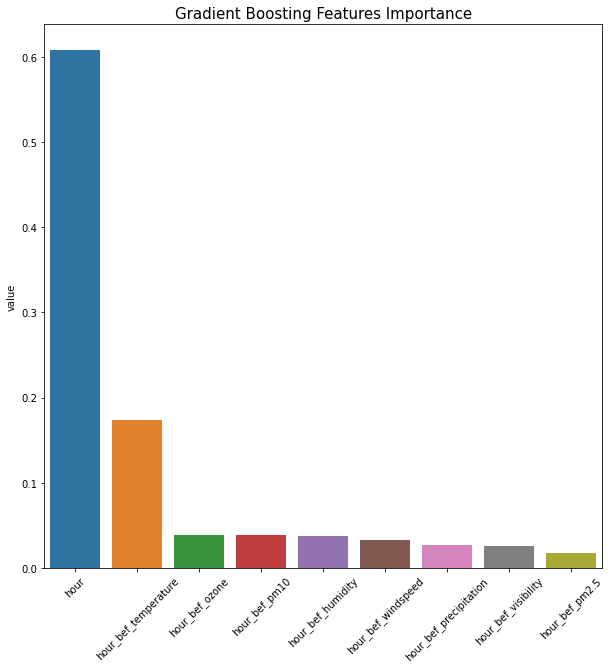

In [69]:
col_imp3 = pd.DataFrame(best_param_gbc_gs.feature_importances_, index = X_train.columns, columns = ['value']).sort_values(by='value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(col_imp3.index, col_imp3['value'])
plt.title('Gradient Boosting Features Importance', fontsize=15)
plt.xticks(rotation=45)

C:\Users\h2est\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'hour_bef_precipitation'),
  Text(2, 0, 'hour_bef_temperature'),
  Text(3, 0, 'hour_bef_ozone'),
  Text(4, 0, 'hour_bef_visibility'),
  Text(5, 0, 'hour_bef_pm10'),
  Text(6, 0, 'hour_bef_humidity'),
  Text(7, 0, 'hour_bef_pm2.5'),
  Text(8, 0, 'hour_bef_windspeed')])

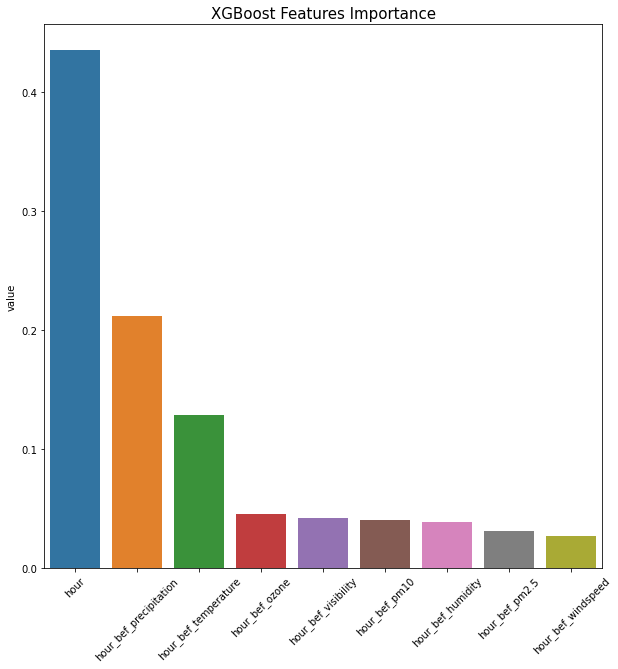

In [70]:
col_imp4 = pd.DataFrame(best_param_xgb_gs.feature_importances_, index = X_train.columns, columns = ['value']).sort_values(by='value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(col_imp4.index, col_imp4['value'])
plt.title('XGBoost Features Importance', fontsize=15)
plt.xticks(rotation=45)

C:\Users\h2est\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'hour'),
  Text(1, 0, 'hour_bef_temperature'),
  Text(2, 0, 'hour_bef_ozone'),
  Text(3, 0, 'hour_bef_pm10'),
  Text(4, 0, 'hour_bef_windspeed'),
  Text(5, 0, 'hour_bef_humidity'),
  Text(6, 0, 'hour_bef_visibility'),
  Text(7, 0, 'hour_bef_pm2.5'),
  Text(8, 0, 'hour_bef_precipitation')])

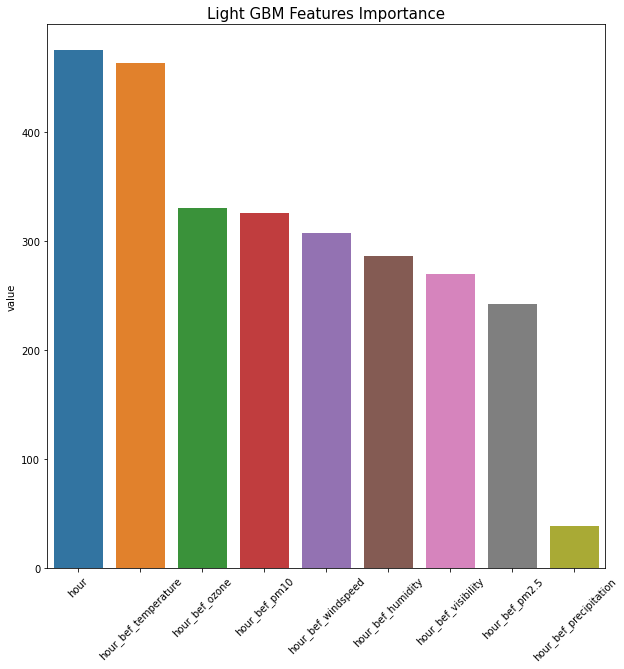

In [71]:
col_imp5 = pd.DataFrame(best_param_lgb_gs.feature_importances_, index = X_train.columns, columns = ['value']).sort_values(by='value', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(col_imp5.index, col_imp5['value'])
plt.title('Light GBM Features Importance', fontsize=15)
plt.xticks(rotation=45)